In [9]:
import numpy as np

with open('data/text_data/japan.txt', 'r') as f:
    txt = f.read()

    X = []
    y = []

    char_to_idx = {char: i for i, char in enumerate(set(txt))}
    idx_to_char = {i: char for i, char in enumerate(set(txt))}

    X = np.array([char_to_idx[x] for x in txt])
    y = [char_to_idx[x] for x in txt[1:]]
    y.append(char_to_idx['.'])
    y = np.array(y)

In [10]:
import impl.layer as l

class GRU2:

    def __init__(self, D, H, L, char2idx, idx2char, p_dropout):
        self.D = D
        self.H = H
        self.L = L
        self.char2idx = char2idx
        self.idx2char = idx2char
        self.vocab_size = len(char2idx)
        self.losses = {'train':[], 'smooth train':[]}
        self.p_dropout = p_dropout
        
        # Model parameters
        Z = H + D
        m = dict(
            Wz=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wh=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wy=np.random.randn(H, D) / np.sqrt(H / 2.),
            bz=np.zeros((1, H)),
            bh=np.zeros((1, H)),
            by=np.zeros((1, D))
        )
        
        self.model = []
        for _ in range(self.L):
            self.model.append(m)
            
    def initial_state(self):
        return np.zeros((1, self.H))

    # p_dropout == keep_prob in this case!
    # p = p_dropout and q = keep_prob => q = 1-q??
    def dropout_forward(self, X, p_dropout):
        u = np.random.binomial(1, p_dropout, size=X.shape) / p_dropout
        #         q = 1-p_dropout
        #         u = np.random.binomial(1, q, size=X.shape)
        out = X * u
        cache = u
        return out, cache

    def dropout_backward(self, dout, cache):
        dX = dout * cache
        return dX
    
    def forward(self, X, h, m, train):
        Wz, Wh, Wy = m['Wz'], m['Wh'], m['Wy']
        bz, bh, by = m['bz'], m['bh'], m['by']

        X_one_hot = X.copy()
        h_old = h.copy()

        X = np.column_stack((h_old, X_one_hot))

        hz, hz_cache = l.fc_forward(X, Wz, bz)
        hz, hz_sigm_cache = l.sigmoid_forward(hz)

        hh, hh_cache = l.fc_forward(X, Wh, bh)
        hh, hh_tanh_cache = l.tanh_forward(hh)

        h = h_old + (hz * (hh - h_old))
        y, y_cache = l.fc_forward(h, Wy, by)

        if train:
            y, do_cache = self.dropout_forward(X=y, p_dropout=self.p_dropout)
            cache = (h_old, X_one_hot, hz, hz_cache, hz_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache, do_cache)
        else:
            cache = h_old, X_one_hot, hz, hz_cache, hz_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache

        return y, h, cache

    def backward(self, dy, dh, cache, train):
        if train:
            h_old, X_one_hot, hz, hz_cache, hz_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache, do_cache = cache
            dy = self.dropout_backward(dout=dy, cache=do_cache)
        else:
            h_old, X_one_hot, hz, hz_cache, hz_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache = cache
        
        dh_next = dh.copy()

        dh, dWy, dby = l.fc_backward(dy, y_cache)
        dh += dh_next
        dh_old1 = (1. - hz) * dh

        dhh = hz * dh
        dhh = l.tanh_backward(dhh, hh_tanh_cache)
        dX, dWh, dbh = l.fc_backward(dhh, hh_cache)
        
        dh_old2 = dX[:, :self.H]
        dX1 = dX[:, self.H:]

        dhz = (hh - h_old) * dh
        dhz = l.sigmoid_backward(dhz, hz_sigm_cache)
        dX, dWz, dbz = l.fc_backward(dhz, hz_cache)
        
        dh_old3 = dX[:, :self.H]
        dX2 = dX[:, self.H:]

        dh = dh_old1 + dh_old2 + dh_old3
        dX = dX1 + dX2

        grad = dict(Wz=dWz, Wh=dWh, Wy=dWy, bz=dbz, bh=dbh, by=dby)
        
        return dX, dh, grad
    
    def train_forward(self, X_train, h):
        ys, caches = [], []
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())
            caches.append([])
            
        for X in X_train:
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.
            y = X_one_hot.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], cache = self.forward(y, h[layer], self.model[layer], train=True)
                caches[layer].append(cache)
                
            ys.append(y)
            
        return ys, caches

    def cross_entropy(self, y_pred, y_train):
        m = y_pred.shape[0]

        prob = l.softmax(y_pred)
        log_like = -np.log(prob[range(m), y_train])
        data_loss = np.sum(log_like) / m

        return data_loss

    def dcross_entropy(self, y_pred, y_train):
        m = y_pred.shape[0]

        grad_y = l.softmax(y_pred)
        grad_y[range(m), y_train] -= 1.0
        grad_y /= m

        return grad_y
    
    def loss_function(self, y_train, ys):
        loss, dys = 0.0, []

        for y_pred, y in zip(ys, y_train):
            loss += self.cross_entropy(y_pred, y)
            dy = self.dcross_entropy(y_pred, y)
            dys.append(dy)
            
        return loss, dys

    def train_backward(self, dys, caches):
        dh, grad, grads = [], [], []
        for layer in range(self.L):
            dh.append(np.zeros((1, self.H)))
            grad.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
            grads.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
            
        for t in reversed(range(len(dys))):
            dX = dys[t]
            for layer in reversed(range(self.L)):
                dX, dh[layer], grad[layer] = self.backward(dX, dh[layer], caches[layer][t], train=True)
                for key in grad[layer].keys():
                    grads[layer][key] += grad[layer][key]
                
        return dX, grads
    
    def test(self, X_seed, h, size):
        chars = [self.idx2char[X_seed]]
        idx_list = list(range(self.vocab_size))
        X = X_seed
        
        h_init = h.copy()
        h = []
        for layer in range(self.L):
            h.append(h_init.copy())

        for _ in range(size):
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.
            y = X_one_hot.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], _ = self.forward(y, h[layer], self.model[layer], train=False)
                
            prob = l.softmax(y)
            idx = np.random.choice(idx_list, p=prob.ravel())
            chars.append(self.idx2char[idx])
            X = idx

        return ''.join(chars)

In [11]:
from sklearn.utils import shuffle as skshuffle

def get_minibatch(X, y, minibatch_size, shuffle):
    minibatches = []

    if shuffle:
        X, y = skshuffle(X, y)

    for i in range(0, X.shape[0], minibatch_size):
#     for i in range(0, X.shape[0] - minibatch_size + 1, 1):
        X_mini = X[i:i + minibatch_size]
        y_mini = y[i:i + minibatch_size]
        minibatches.append((X_mini, y_mini))

    return minibatches

def adam_rnn(nn, X_train, y_train, alpha, mb_size, n_iter, print_after):
    M, R = [], []
    for layer in range(nn.L):
        M.append({key: np.zeros_like(val) for key, val in nn.model[layer].items()})
        R.append({key: np.zeros_like(val) for key, val in nn.model[layer].items()})
        
    beta1 = .99
    beta2 = .999
    state = nn.initial_state()
    smooth_loss = 1.0
    eps = 1e-8
    minibatches = get_minibatch(X_train, y_train, mb_size, shuffle=False)

    # Epochs
    for iter in range(1, n_iter + 1):

        # Minibatches
        for idx in range(len(minibatches)):
            X_mini, y_mini = minibatches[idx]
            ys, caches = nn.train_forward(X_mini, state)
            loss, dys = nn.loss_function(y_mini, ys)
            _, grads = nn.train_backward(dys, caches)
            nn.losses['train'].append(loss)
            smooth_loss = (0.999 * smooth_loss) + (0.001 * loss)
            nn.losses['smooth train'].append(smooth_loss)

            for layer in range(nn.L):
                for key in grads[layer].keys(): #key, value: items
                    M[layer][key] = l.exp_running_avg(M[layer][key], grads[layer][key], beta1)
                    R[layer][key] = l.exp_running_avg(R[layer][key], grads[layer][key]**2, beta2)

                    m_k_hat = M[layer][key] / (1. - (beta1**(iter)))
                    r_k_hat = R[layer][key] / (1. - (beta2**(iter)))

                    nn.model[layer][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + eps)

        # Print loss and test sample
        if iter % print_after == 0:
            print('Iter-{} loss: {:.4f}'.format(iter, loss))
            sample = nn.test(X_mini[0], state, size=100)
            print(sample)
            
    return nn

Iter-10 loss: 105.9075
eyputWe slepggWhneynhez i.e soa本- Keogh roo s eee Jn0deli e nsat iaa nar
anposnrna a-orDhanccfl52t;at
Iter-20 loss: 103.3722
eyKretIrat7ryJrhd:oeb b nriaeai thd o  ,e br   t Uie     od,gtlnses ytcffnre   wx6aaoohnaee o Hd wCnt
Iter-30 loss: 100.8267
elanppdipu o eo本, oijno d,esG udediafsw ethtryshpscsai gop;oeneitnkdhazcty日eee lhaatrgaatd smmihnafer
Iter-40 loss: 103.5037
eu.oc)ofcePanixsaeI ei6lJa tOtaher pu nieNe.( riakh g;8ty ritffao neJ-rsar.tnmac8ts r1rtdestpeo Aieco
Iter-50 loss: 103.3519
e5at snmd ootefa;ao k srshiuapa hu hntrdPosi nBTn tonoo niige ytn  po  nippt 1rdisotst etesitoi satra
Iter-60 loss: 104.9808
etyygr phn; rouyamfay e ho hgeiie5gag JnoTiak saataC neehutae mn,eap-y aefW cakiap  onennh.tf  unasTn
Iter-70 loss: 101.8191
eOe eRarf  Ge rhcrtu dhoyds drdlctnear  ;- arnboiey k r4deufhcoNhetie9ihma al  iaeyhvAiaNi dh sJincc 
Iter-80 loss: 105.7464
e.rre e hu upo7sp u  auNe  tnhnwal plresph k%iwdhsen p"n r saghnitwnette  nasta rni e hu nLsteteba  K


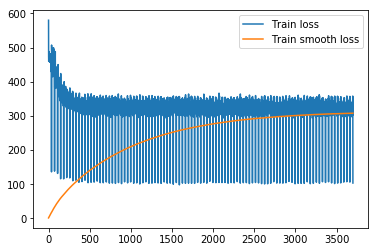

In [13]:
# Hyper-parameters
time_step = 100 # width, minibatch size and test sample size as well
num_layers = 50 # depth
n_iter = 100 # epochs
alpha = 1e-4 # learning_rate
p_dropout = 0.95 # q=1-p, q=keep_prob and p=dropout.
print_after = n_iter//10 # print training loss, valid, and test
num_hidden_units = 64 # num_hidden_units in hidden layer
num_input_units = len(char_to_idx) # vocab_size = len(char_to_idx)

# Build the network and learning it or optimizing it using SGD
net = GRU2(D=num_input_units, H=num_hidden_units, L=num_layers, char2idx=char_to_idx, idx2char=idx_to_char, 
          p_dropout=p_dropout)

# Start learning using BP-SGD-ADAM
adam_rnn(nn=net, X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.plot(net.losses['smooth train'], label='Train smooth loss')
plt.legend()
plt.show()

Iter-1 loss: 127.4870
eHIi'1ueTpBuiuv;i'1eupiuohkkhh,UhTa
iphauetpuguB-m,本m'e,rMsRsmjhk9T)s;hgo本h),ee-Feoeke,xxm;'hrMeigd15
Iter-2 loss: 112.1980
ecoE,1oh,hK ndiksa dyapm maJeime mueo–mhi'd CJiknB t"dBpc'eocanuaG1cA,ni J
sB eheimmd–yTc0 3GxEDRium:
Iter-3 loss: 106.0030
enLAe9neaSeh1Bklo  osrT te)euLg-I,lame hldcyusm'eBi peiniidt   ,psaI Tetn i
e(uIm05y"cuOl3todldg ,neT
Iter-4 loss: 104.2500
euh5htehla t el  yatneNteh-iaieiyos erB-ytornna日oet本oNaCp Nmeo tutnT os 0gatyecon aatot roCc ;xlhikec
Iter-5 loss: 106.1209
et-rdw5eeog  tco- hp'am WieraCmhapn nscerrtehid"S  pmltcEhJcgm)o1- aefiracrWrteslaf u rskCe Aohto ati
Iter-6 loss: 105.7978
e ;edr   aod  e  ataceuBlcr   "ce iarB  nat, rdto9 SnasrBon本rp tI:e –o 2setia p hethfy htoiff aatt so
Iter-7 loss: 104.8000
elrWhe ettBi e  riyJos i  c-rtr aim. rrD ah ihaamlai   itt  dpiSopai ieodgsodrl  w .tpct ntdnni Ccpdh
Iter-8 loss: 102.2460
e日5igmJ  aeIln ocasheai lei,Ie4 hTnianoof mnciaido.dh  kj nplnnatn h1k  rticn cscWrvloa ce o tsnIef p
Iter-9 l

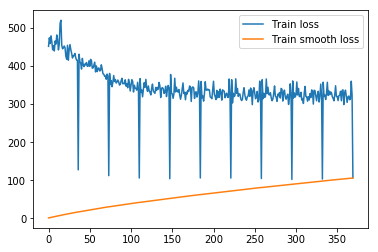

In [12]:
# Hyper-parameters
time_step = 100 # width, minibatch size and test sample size as well
num_layers = 50 # depth
n_iter = 10 # epochs
alpha = 1e-4 # learning_rate
p_dropout = 0.95 # q=1-p, q=keep_prob and p=dropout.
print_after = n_iter//10 # print training loss, valid, and test
num_hidden_units = 64 # num_hidden_units in hidden layer
num_input_units = len(char_to_idx) # vocab_size = len(char_to_idx)

# Build the network and learning it or optimizing it using SGD
net = GRU2(D=num_input_units, H=num_hidden_units, L=num_layers, char2idx=char_to_idx, idx2char=idx_to_char, 
          p_dropout=p_dropout)

# Start learning using BP-SGD-ADAM
adam_rnn(nn=net, X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.plot(net.losses['smooth train'], label='Train smooth loss')
plt.legend()
plt.show()

Iter-1 loss: 132.4279
eHMJ2y 本Cdv;%7elTi-yRO:U8xv1-NH0–FBvLexL;SFO-本0Ce:s–kwNn;rHcicb";"g5r6FFtnU本–ebESFId4SrrJmcxu'tigP'ce
Iter-2 loss: 122.1108
eUR ep-日e0e TrS: r.–"GI0. si  r"LP "e本 -h3ik本E s本l0o0l日ad6 e本)essi  lA3lns1本 ob201Pxr20n0p"  m:i"2e本本
Iter-3 loss: 111.5100
e P"e rpn hcc 8LehhUo0if-yr3 :"l r;-snhh4aRi R rta
nlhe  :dfaor  Br.i:f1)-
 Rieb p2dr . U%E-0ih Shnoh
Iter-4 loss: 106.2680
e)h4tr eWcn p:nctt plP) R本 9taei  nK c 0:"  ln r9d9a htn rn pad-oahle ni8本
nvirnp ryoh  tt4pltri ha
w
Iter-5 loss: 100.1685
eia aaihta本D t-"a,i7 no hT tpztdt,rittrn ,eani 2本y0pihhfngeep
di)eziiUiiery p本1nneoe,lpaiga Tie.本r.- 
Iter-6 loss: 114.2790
eKsy8Necil1Br)nvF;(u%rc%Er7'GErurFNrnHmrsd7cnwLmumdd6GIHkIcc3GrlnsccB9gcd;T%edkprne7T,%RusrTcp;39RTmv
Iter-7 loss: 129.9785
eW9uy:i9rxAWETOD nkcOE.;tcU3eTo 3o0koechw3 eeeWone3
roeokin neiiekmm yc'i89 c Toing9nronence3eEfconek
Iter-8 loss: 109.6622
eitEmmWnaahnRCWndkn h7nhb ntGdcnMGh EwItno iE.Ithk)etcD2setthdd(tabOtar本kuinTikonnpn WhlLWeUbnneehiec
Iter-9 l

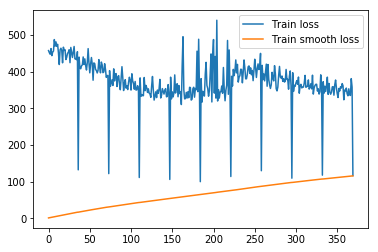

In [8]:
# Hyper-parameters
time_step = 100 # width, minibatch size and test sample size as well
num_layers = 40 # depth
n_iter = 10 # epochs
alpha = 1e-4 # learning_rate
p_dropout = 0.95 # q=1-p, q=keep_prob and p=dropout.
print_after = n_iter//10 # print training loss, valid, and test
num_hidden_units = 64 # num_hidden_units in hidden layer
num_input_units = len(char_to_idx) # vocab_size = len(char_to_idx)

# Build the network and learning it or optimizing it using SGD
net = GRU2(D=num_input_units, H=num_hidden_units, L=num_layers, char2idx=char_to_idx, idx2char=idx_to_char, 
          p_dropout=p_dropout)

# Start learning using BP-SGD-ADAM
adam_rnn(nn=net, X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.plot(net.losses['smooth train'], label='Train smooth loss')
plt.legend()
plt.show()

Iter-1 loss: 123.5279
eAepB ipe)'o n)poAB6si a B Np日'e uchliJv7Age 'zc cy"o  'eiJ 50 h  7siy)yy)FyurgE6c
oN  ' A)L ;AoJcla1
Iter-2 loss: 115.3323
eSnnnwnsape1oaop  P  I"Nydzhnl7oitCd y'ltrc nsEFe.m e ee0 ornrFetn)vgroCm hy h ''yirta odys aot本ej r 
Iter-3 loss: 111.5339
e.h6 "– rhdln iaLhKhedkdd1tfe  I ht a日  ievnno;tdsKhim  apzj  'c 0sedal iy AeitnhoJnKio "KhioaaL.tnoa
Iter-4 loss: 107.6487
e
 hdt h ThhBe  dlii mia oohpy o ltn  s9  nmsa ctt  seoih .daene
ssiiandnoneareyistst iecarhclnKtsJvg
Iter-5 loss: 107.1631
entke  nhgpae dszr'ssa d iyw nhbrhasj)a tf i  g cv-.omeu"bnos rieonear2ovt ttgirelhN'atoitlis d sansa
Iter-6 loss: 108.5153
e l'acaFhiNuS2pu) llcgidit本sa8 cooitrarogeBPE"Bywl st  c e  –ie th'ntis.nJaari  aeTst oeCt r Ogttvenl
Iter-7 loss: 104.0800
eJgafiafB eet aeerolo  msiire uGeresenefsohB ithiyotxaaraa h nslnr nhfeoc6taTsd pr oc.ienn nfiianikTn
Iter-8 loss: 104.6021
ecippis oa f ns oe-isteilmuhi itlunnej"ntt"u  snrenEiaodsSdets  itI Erncvelea'ir tilSw mia)    rmen e
Iter-9 l

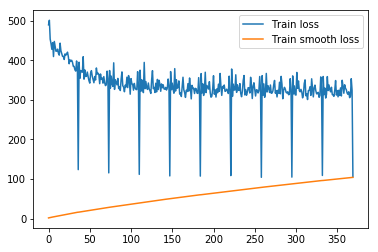

In [7]:
# Hyper-parameters
time_step = 100 # width, minibatch size and test sample size as well
num_layers = 30 # depth
n_iter = 10 # epochs
alpha = 1e-4 # learning_rate
p_dropout = 0.95 # q=1-p, q=keep_prob and p=dropout.
print_after = n_iter//10 # print training loss, valid, and test
num_hidden_units = 64 # num_hidden_units in hidden layer
num_input_units = len(char_to_idx) # vocab_size = len(char_to_idx)

# Build the network and learning it or optimizing it using SGD
net = GRU2(D=num_input_units, H=num_hidden_units, L=num_layers, char2idx=char_to_idx, idx2char=idx_to_char, 
          p_dropout=p_dropout)

# Start learning using BP-SGD-ADAM
adam_rnn(nn=net, X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.plot(net.losses['smooth train'], label='Train smooth loss')
plt.legend()
plt.show()

Iter-1 loss: 119.5858
eg1::xxp:gOe3zxJgxsrBJo4–5i Ipi a"ipMs-t'a0p k-,Rx2hilxKO0L-0:4hnn0 xBhlaee4zaWG LkWnharai FDacMfPauJ
Iter-2 loss: 111.2903
etast7p11 Wip 6a tEasbr50op7Mf2s taasoc awaaeob5  aeiebihinc M :uDt
mhiytahw.   M  f zoD  W日ieve :h P
Iter-3 loss: 104.8620
e;1u:2idtvWDe Up s:imorepeim efrtc,aust tsu mttuRsivpW t :aihcwoD t Uitocro rebbJ
antapxfzeotoennps  
Iter-4 loss: 107.0888
ez i1umiopenri u d  日a   iti  f  tner y oet  sducehenr sk4 eci. ae.l7eteudd.t rhe v rKah1t  n ytfh2ii
Iter-5 loss: 103.8761
eh9u oodri try ea7e,ao rn tPd  smse.tc hlyhroe Jnritoy rhd avauei  eRahdoa yeoncuvp  2snrpeB5 rOrtmc 
Iter-6 loss: 103.1679
e(fgngt9 aanrefsrsr seEuc sw Jin8 rnn-rh  nrrninOifEca ntas lrgai aJ ai Bsaeus spemylttipgtaerrhguF m
Iter-7 loss: 102.1522
e日msirRrta rnlamWyet iuei  do rrdae ttraaoral,no rodr tWJouosed'r :F rslr deuW9itxWdtn    isbtnereudf
Iter-8 loss: 107.0316
enM olaitnaegph   t2 lhaoef or  e i  Mecthn.tDtho tWdhmospgah. elrpwie iaru   t or ' neded eotea nnep
Iter-9 l

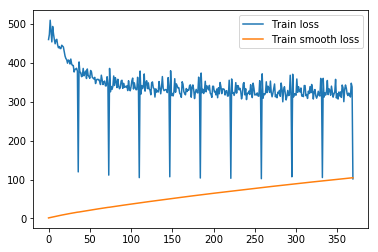

In [6]:
# Hyper-parameters
time_step = 100 # width, minibatch size and test sample size as well
num_layers = 20 # depth
n_iter = 10 # epochs
alpha = 1e-4 # learning_rate
p_dropout = 0.95 # q=1-p, q=keep_prob and p=dropout.
print_after = n_iter//10 # print training loss, valid, and test
num_hidden_units = 64 # num_hidden_units in hidden layer
num_input_units = len(char_to_idx) # vocab_size = len(char_to_idx)

# Build the network and learning it or optimizing it using SGD
net = GRU2(D=num_input_units, H=num_hidden_units, L=num_layers, char2idx=char_to_idx, idx2char=idx_to_char, 
          p_dropout=p_dropout)

# Start learning using BP-SGD-ADAM
adam_rnn(nn=net, X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.plot(net.losses['smooth train'], label='Train smooth loss')
plt.legend()
plt.show()

Iter-1 loss: 116.7948
eKNcWfLd5(–Oe–SCE22日2m acdMEu:Wa Kdo 1da   Rn8tJ8ODa%taNha 8l日dpvlnaoj 3r日avt日oo3nm 17tyJeaEz8h;trwyn
Iter-2 loss: 114.1162
e.B v本':ex  2nd2ot2gNF本i:y'a  faoMdJe日o8nldod"tm  mRJ E%  bd6emIsesh ireRt sedeoBv(C 7id ,hs enCp  fs
Iter-3 loss: 114.3079
eH-  N:5G9Hd(POsWra4dEWuE3hhe sdn annef n oe1 cyrnshhedceoiose.e  rceSioine,rpt2h ii oDrtsiheeLnohJa 
Iter-4 loss: 116.5167
eGjI gO ln.ewjt   sou oidl s 1vynncNto dn 5"oe  sdo5dtl  i eltnfeonv ty Ciaodno  sipteenl nnd On e3ht
Iter-5 loss: 108.7438
esdoll"b.rzfhiifaKEegnR r8ahyEomh hese  l  Jhrddnatnlgiirlnifhnh.ktsngjxtupeeewh 日rattca d oEe  se pi
Iter-6 loss: 107.8926
e(rs 9Wvnlena i0f y avnieaeiufamtirpu 9  . tiienloitt sarrnkipJ:ceknras caocnmhprrros  innByeusntpow 
Iter-7 loss: 107.8428
efNlla2'dmwphiroreeeaaryc Cf surhU nthAaw s xeltl uycr  sa xiDOe ttcl4 tgieihn aunlh h rt ls i dovs  
Iter-8 loss: 109.4417
eH 8ekkooh  g P denveftutfinaia tgrsftrntn dxar Ei   E n  vaernaye ngriertgtglo   tc  tEmhteei.gJnfhp
Iter-9 l

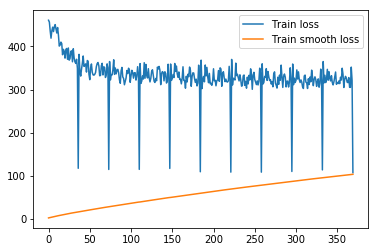

In [5]:
# Hyper-parameters
time_step = 100 # width, minibatch size and test sample size as well
num_layers = 10 # depth
n_iter = 10 # epochs
alpha = 1e-4 # learning_rate
p_dropout = 0.95 # q=1-p, q=keep_prob and p=dropout.
print_after = n_iter//10 # print training loss, valid, and test
num_hidden_units = 64 # num_hidden_units in hidden layer
num_input_units = len(char_to_idx) # vocab_size = len(char_to_idx)

# Build the network and learning it or optimizing it using SGD
net = GRU2(D=num_input_units, H=num_hidden_units, L=num_layers, char2idx=char_to_idx, idx2char=idx_to_char, 
          p_dropout=p_dropout)

# Start learning using BP-SGD-ADAM
adam_rnn(nn=net, X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.plot(net.losses['smooth train'], label='Train smooth loss')
plt.legend()
plt.show()